In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import Bokeh modules for interactive plotting
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, show
from bokeh.models import HoverTool

# Enable output in notebook
output_notebook()


Loading BokehJS ...

In [9]:
endangered = pd.read_csv('./data/endangered_species.csv')
production = pd.read_csv('./data/world_production_new.csv')
threat = pd.read_csv('./data/threatened_species_by_country.csv')


In [10]:
# convert the years that have the format 2014-3 into 2014

def convert_year(year):
	'''
	Converts the year into a consistent format (for example: from 2014-3 to 2014)
	
	year (string): the year to be converted
	return (string): the converted year
	'''
	year = str(year)
	if '-' in year:
		year = year.split('-')[0]
		year = str(int(year))
		return float(year)
	elif '.' in year:
		year = year.split('.')[0]
		year = str(int(year))
		return float(year)
	elif '‐' in year:
		year = year.split('‐')[0]
		year = str(int(year))
		return float(year)
	else:
		return float(year)

endangered['Year'] = endangered['Year'].apply(convert_year)

# replace commas in numbers and turn total column into integers
threat['Total'] = threat['Total'].str.replace(',', '').astype(int)
threat['Plants*'] = threat['Plants*'].str.replace(',', '').astype(int)


In [11]:
# Make a bar graph of the endangered species by year to see data (takes about 5 minutes to run)

#plt.bar(endangered['Year'].astype(str), endangered['Scientific Name'].astype(str), label='Endangered Species')

<BarContainer object of 14 artists>

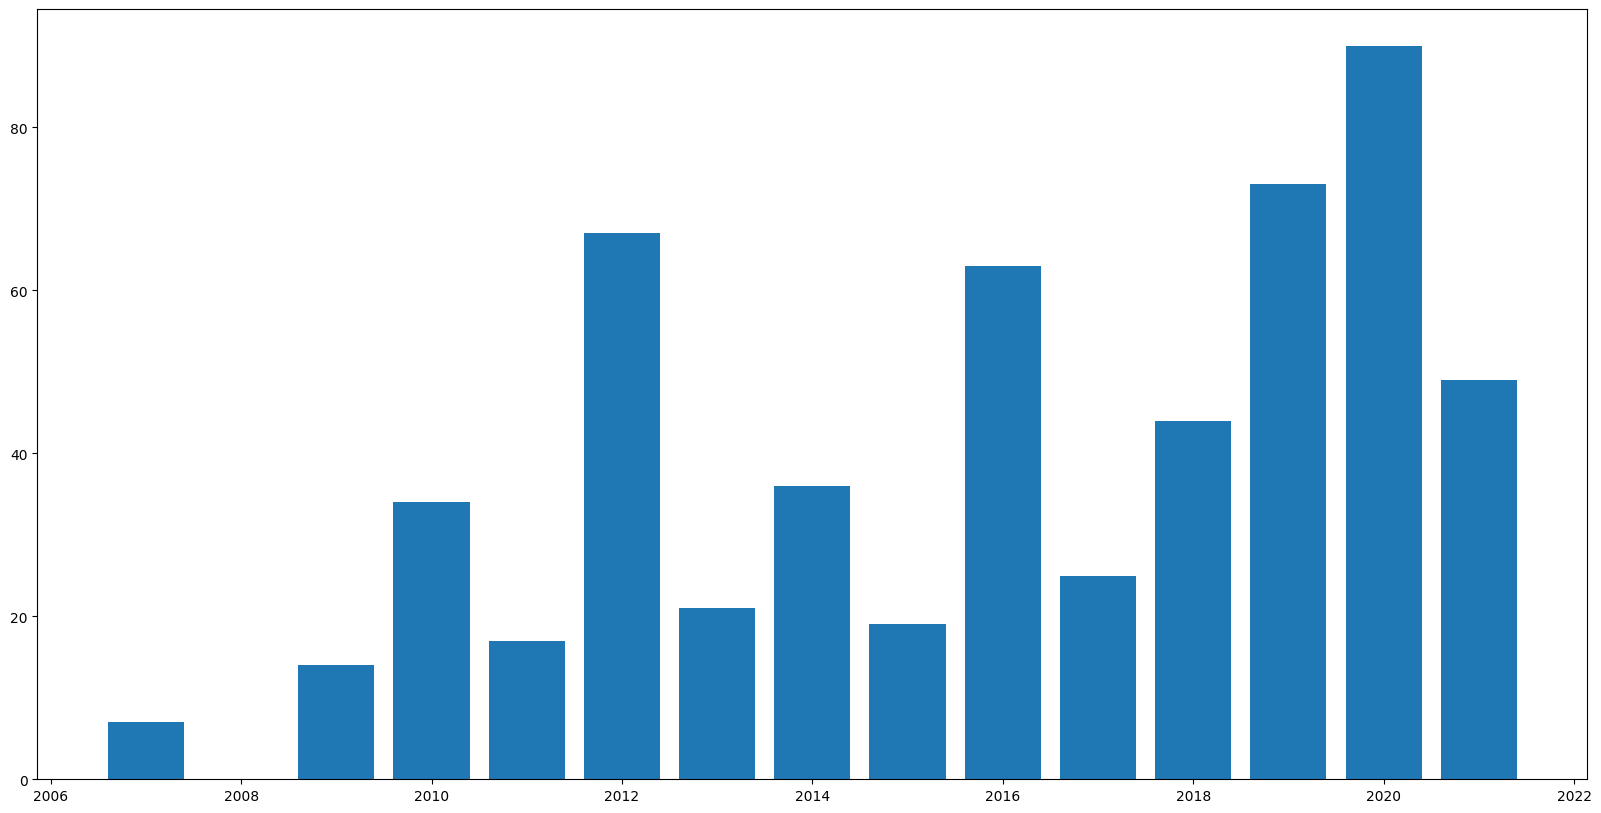

In [12]:
# make a bar graph of the endangered species by year, removing all N and E rows to see data 

# Filter 'endangered' dataframe
endangered_filtered = endangered[endangered['Reason For Change'].isin(['G'])]
endangered_sublist = ['EX', 'EW', 'CR', 'CR(PE)', 'CR(PEW)' 'EN', 'VU']

endangered_critically_endangered = endangered_filtered[endangered_filtered['IUCN Red List Category'].isin(endangered_sublist)]

# Group by 'Year' and count number of occurrences
endangered_year = endangered_critically_endangered.groupby('Year').count().astype(int)
endangered_year = endangered_year.reset_index()

# Select only 'Year' and 'Scientific Name' columns
endangered_year_filtered = endangered_year[['Year', 'Scientific Name']]

# Rename 'Scientific Name' column to 'Species Count'
endangered_year_filtered = endangered_year_filtered.rename(columns={'Scientific Name': 'Species Count'})

# Make bar graph
plt.figure(figsize=(20,10))
plt.bar(x=endangered_year_filtered['Year'], height=endangered_year_filtered['Species Count'])
# plt.scatter(endangered['Year'].astype(str), endangered['Scientific Name'].astype(str), label='Endangered Species')

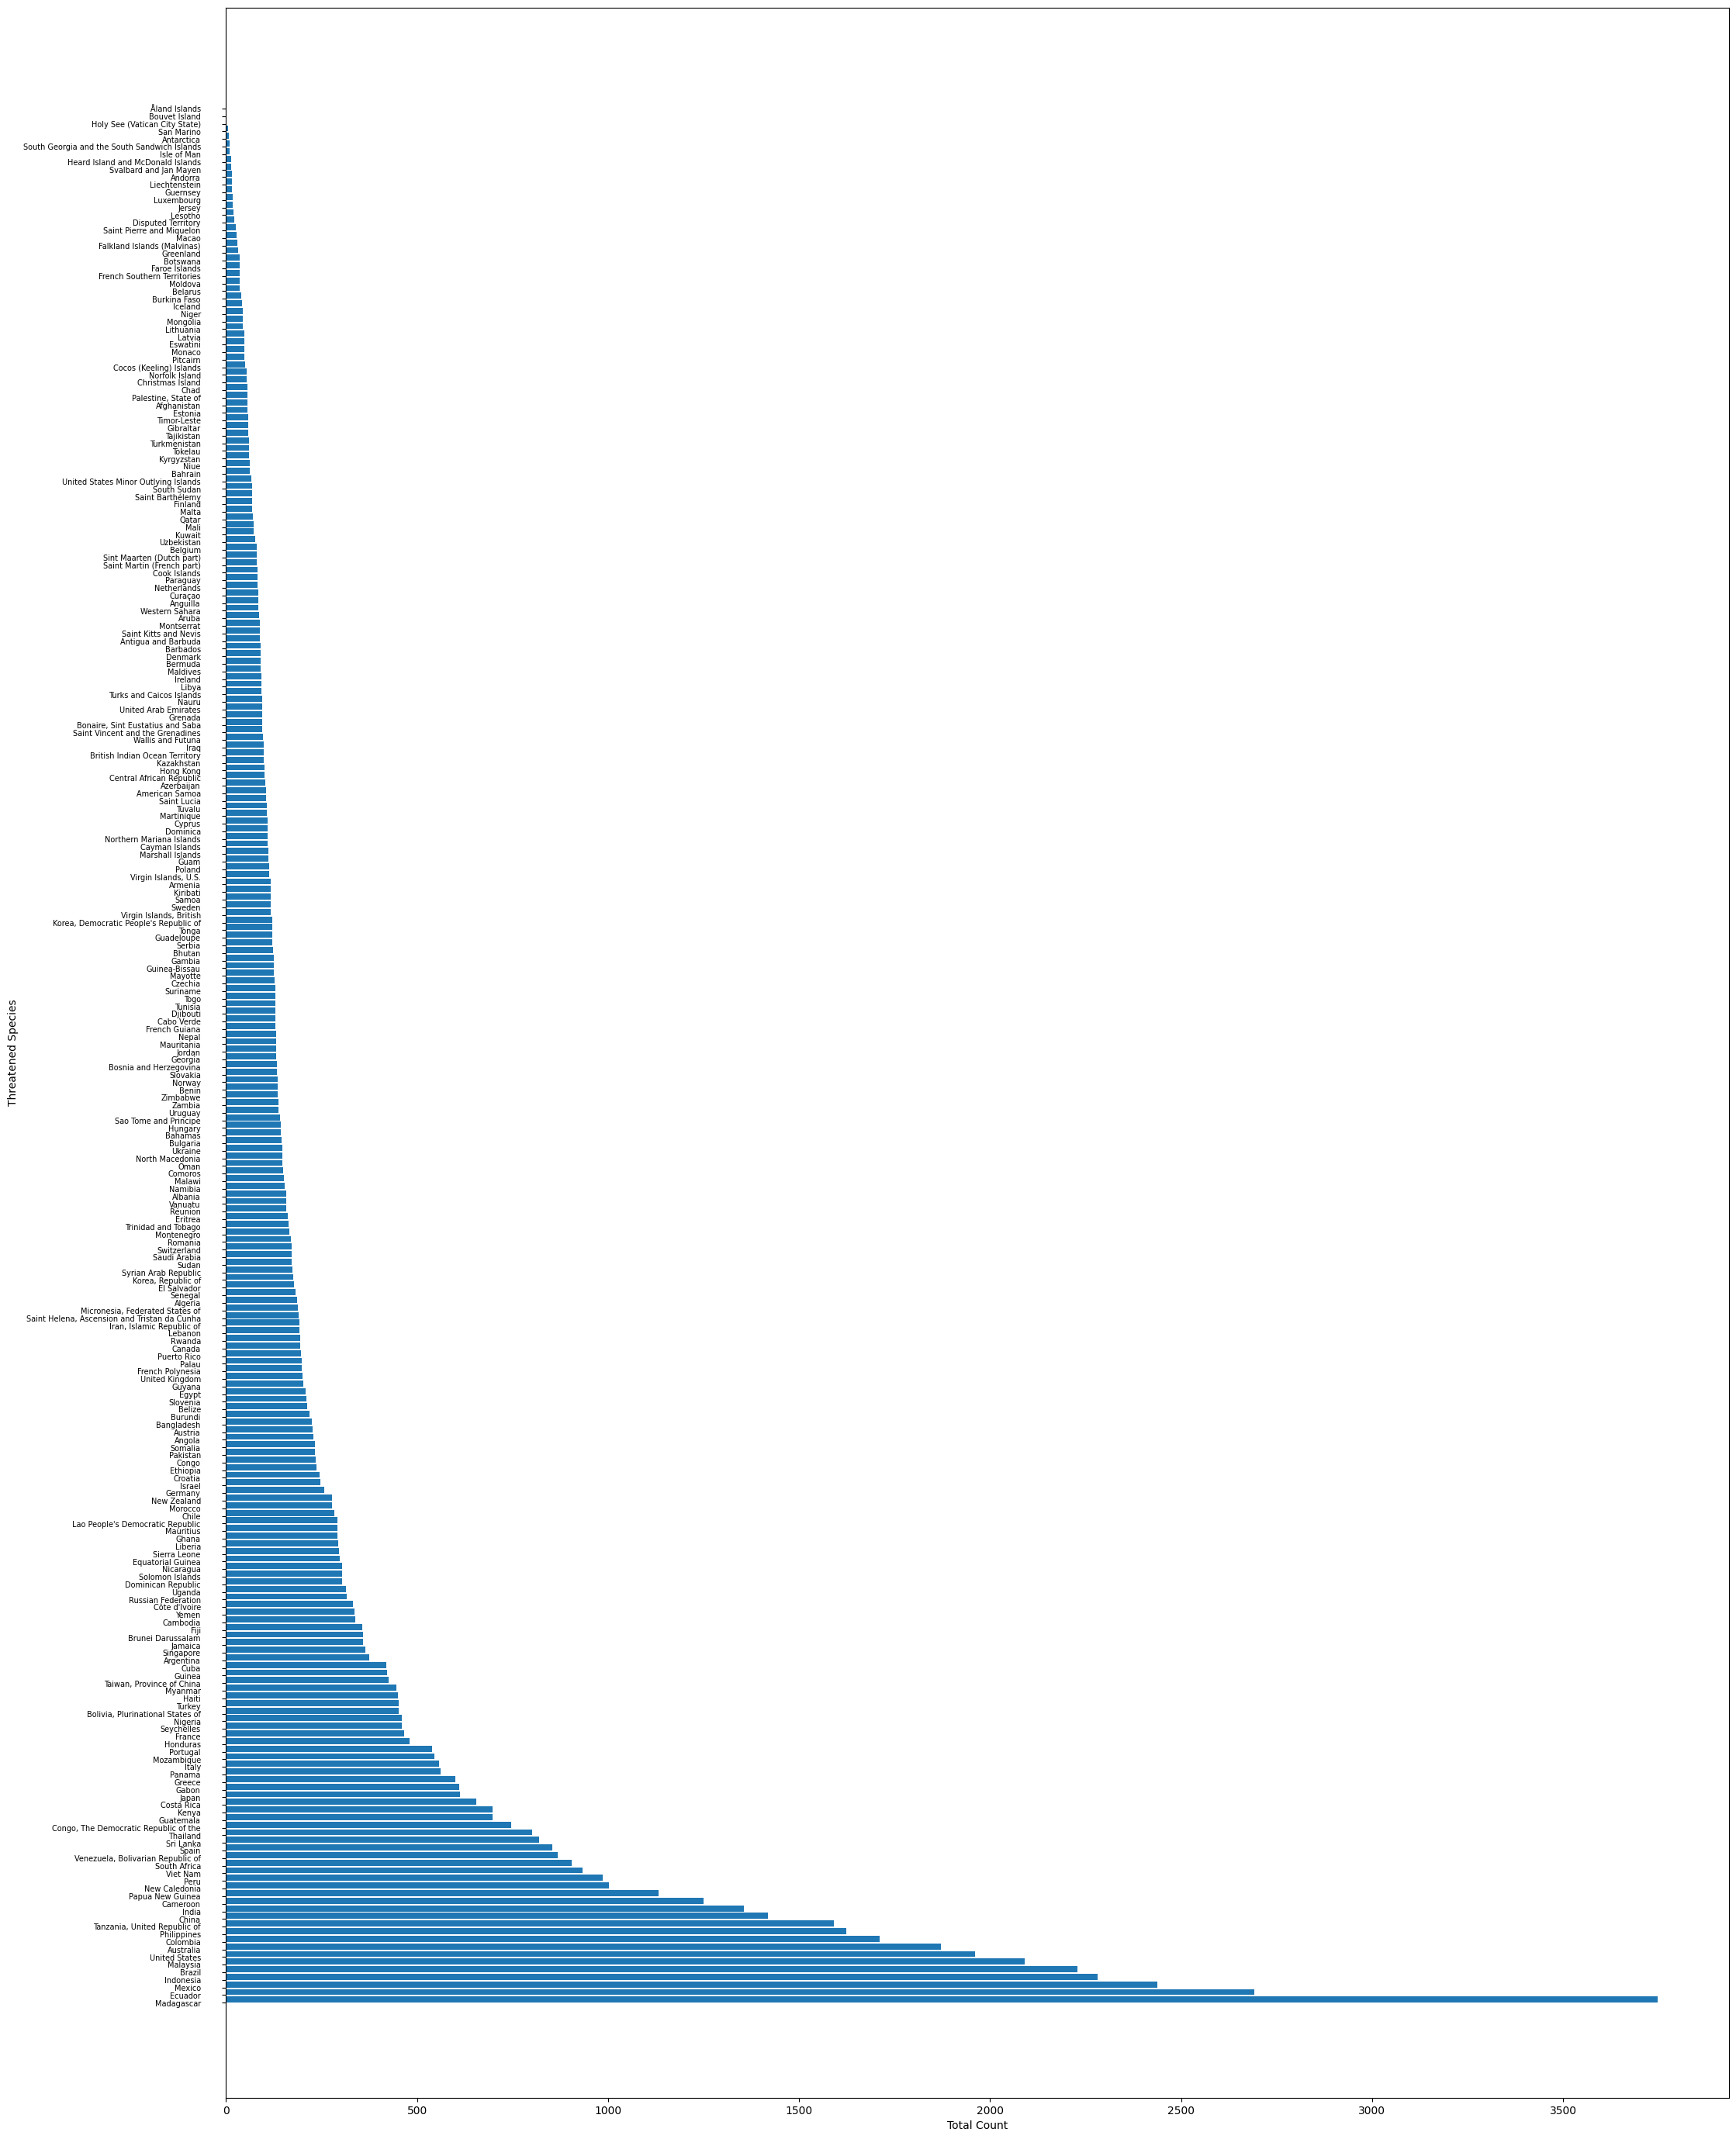

In [13]:
# Make a bar graph of the threatened species by kind to see data

# Group threat dataframe by Name and sum the Total column for each group
threat_filtered = threat.groupby('Name')['Total'].sum().sort_values(ascending=False).reset_index()

# Abbreviate the y-axis tick labels to the first 10 characters
# abbreviated_labels = [label[:10] for label in threat_filtered['Name']]

# Create a horizontal bar graph with abbreviated y-values and widths from the Total column
fig, ax = plt.subplots(figsize=(25, 35))
ax.barh(y=threat_filtered['Name'], width=threat_filtered['Total'], height=0.8, align='edge')

# Set labels for the x-axis and y-axis
ax.set_xlabel('Total Count')
ax.set_ylabel('Threatened Species')

# Reduce font size of y-axis tick labels for readability and adjust spacing
ax.tick_params(axis='y', labelsize=7, pad=20)

plt.show()

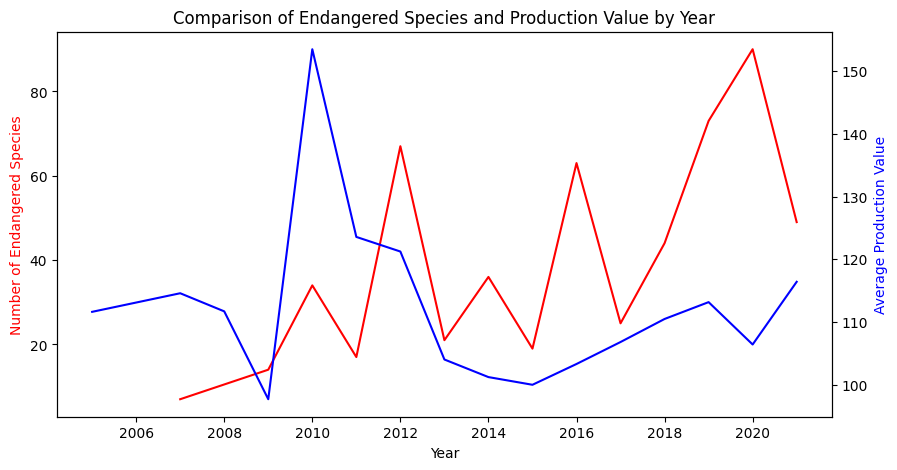

In [14]:
#Compare the average rate of production by year with the number of endangered species by year

# Filter 'production' dataframe by removing 2006 and 2022 and sorting by Year
world_production = production[~production['Year'].isin([2006, 2022])].reset_index(drop=True)

# Calculate the mean production value by year
world_production_avg = world_production.groupby('Year')['Value'].mean().reset_index()
world_production_avg = world_production_avg.rename(columns={'Value': 'Production Value'})

# Group the endangered species data by year

# Plot the two trends on the same chart
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(endangered_year_filtered['Year'], endangered_year_filtered['Species Count'], color='red')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Endangered Species', color='red')

ax2 = ax1.twinx()
ax2.plot(world_production_avg['Year'], world_production_avg['Production Value'], color='blue')
ax2.set_ylabel('Average Production Value', color='blue')

plt.title('Comparison of Endangered Species and Production Value by Year')
plt.show()


C:\Users\Me\AppData\Local\Temp\ipykernel_32652\451931662.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  production_filtered = production.groupby(['Country Description', 'ISIC Description']).sum().reset_index()
C:\Users\Me\AppData\Local\Temp\ipykernel_32652\451931662.py:10: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 10 on the right)
  merged_df = pd.merge(production_filtered, threat_pivot, how='outer', left_on='Country Description', right_on='Name')


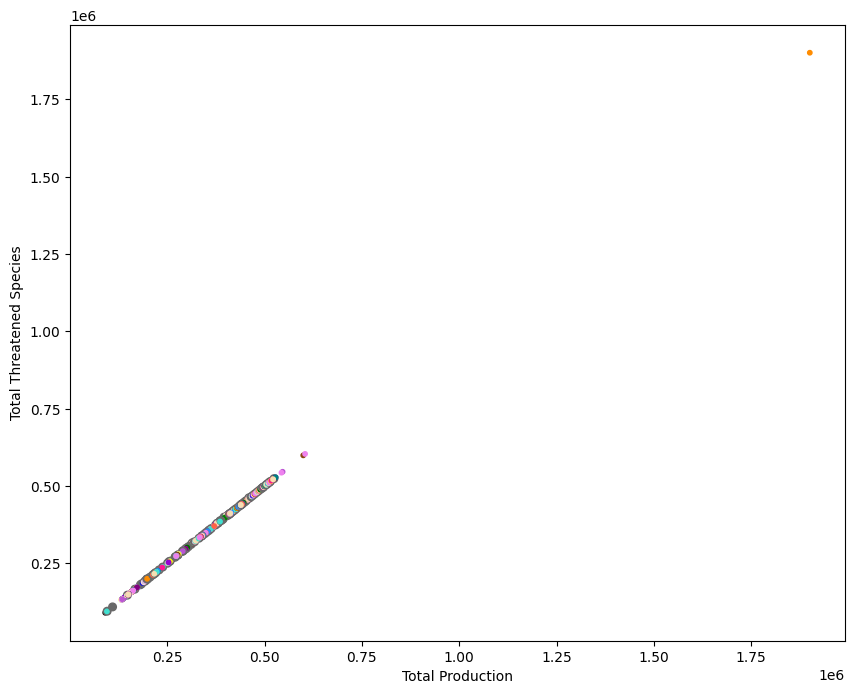

In [15]:
#Compare the type of production in each country with the type of endangered species in each country

# Group production dataframe by Country Description and ISIC Description columns 
production_filtered = production.groupby(['Country Description', 'ISIC Description']).sum().reset_index()

# Pivot threat dataframe to have columns for each threatened species type and values for Total count
threat_pivot = pd.pivot_table(threat, values='Total', index=['Name'], columns=["Mammals","Birds","Reptiles*","Amphibians","Fishes*","Molluscs*","Other Inverts*","Plants*","Fungi*","Chromists*"], fill_value=0)

# Join the two dataframes based on the country column
merged_df = pd.merge(production_filtered, threat_pivot, how='outer', left_on='Country Description', right_on='Name')
merged_df = merged_df.dropna()

# Calculate total production and total threatened species count for each country
merged_df['Total Production'] = merged_df.iloc[:, 2:].sum(axis=1)
merged_df['Total Threatened Species'] = merged_df.iloc[:, -11:].sum(axis=1)


# Create a dictionary to define marker sizes based on the type of production
marker_sizes = {'Agriculture, forestry and fishing': 20,
                'Mining and quarrying': 30,
                'Manufacturing': 40,
                'Electricity, gas, steam and air conditioning supply': 50,
                'Water supply, sewerage, waste management and remediation activities': 60}

# Create a dictionary to define marker colors based on the type of production
marker_colors = {'Basic metals': 'silver',
                 'Beverages': 'blue',
                 'Chemicals and chemical products': 'red',
                 'Coke and refined petroleum products': 'green',
                 'Computer, electronic and optical products': 'yellow',
                 'Electrical equipment': 'purple',
                 'Electricity, gas, steam & air conditioning': 'orange',
                 'Fabricated metal products, except machinery': 'pink',
                 'Food products': 'brown',
                 'Furniture': 'black',
                 'Leather and related products': 'saddlebrown',
                 'Machinery and equipment n.e.c.': 'blue',
                 'Mining and quarrying': 'dimgray',
                 'Motor vehicles, trailers and semi-trailers': 'darkgreen',
                 'Other manufacturing': 'darkorange',
                 'Other non-metallic mineral products': 'darkred',
                 'Other transport equipment': 'darkviolet',
                 'Paper and paper products': 'deeppink',
                 'Pharmaceuticals,medicinal chemicals, etc.': 'dodgerblue',
                 'Printing and reproduction of recorded media': 'snow',
                 'Rubber and plastics products': 'tan',
                 'Textiles': 'teal',
                 'Tobacco products': 'thistle',
                 'Total manufacturing': 'tomato',
                 'Water supply; sewerage, waste management': 'turquoise',
                 'Wearing apparel': 'violet',
                 'Wood products, excluding furniture': 'wheat',
                 'Repair and installation of machinery/equipment': 'mediumorchid',
                 }

# Extract the x, y, size, and color values from the merged_df dataframe
x = merged_df['Total Production']
y = merged_df['Total Threatened Species']
size = [marker_sizes.get(v, 10) for v in merged_df['ISIC Description']]
color = [marker_colors.get(v, 'black') for v in merged_df['ISIC Description']]

# Plot a scatter plot of all the points at once
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(x, y, s=size, c=color)

# Set labels for the x-axis and y-axis
ax.set_xlabel('Total Production')
ax.set_ylabel('Total Threatened Species')

plt.show()

# Set labels for the x-axis and y-axis
ax.set_xlabel('Total Production')
ax.set_ylabel('Total Threatened Species')

plt.show()

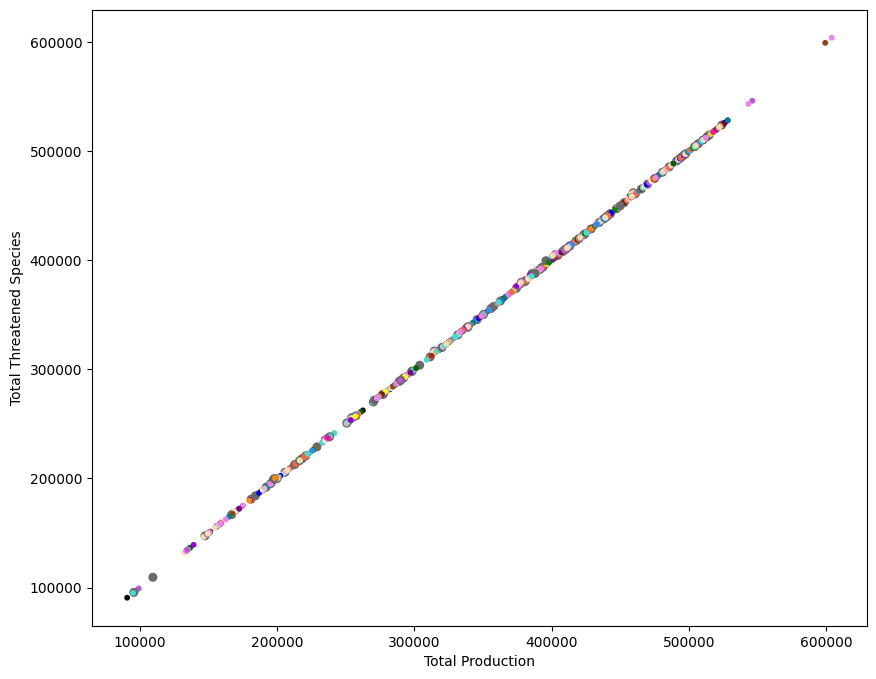

In [16]:
#Chart with outlier filtered out so it is easier to see the rest of the data
merged_df = merged_df[merged_df['Total Production'] <= 1000000]

# Plot a scatter plot to compare the total production and total threatened species count for each country
# Extract the x, y, size, and color values from the merged_df dataframe
x = merged_df['Total Production']
y = merged_df['Total Threatened Species']
size = [marker_sizes.get(v, 10) for v in merged_df['ISIC Description']]
color = [marker_colors.get(v, 'black') for v in merged_df['ISIC Description']]

# Plot a scatter plot of all the points
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(x, y, s=size, c=color)

# Set labels for the x-axis and y-axis
ax.set_xlabel('Total Production')
ax.set_ylabel('Total Threatened Species')

plt.show()


Text(0, 0.5, 'Total Threatened Species')

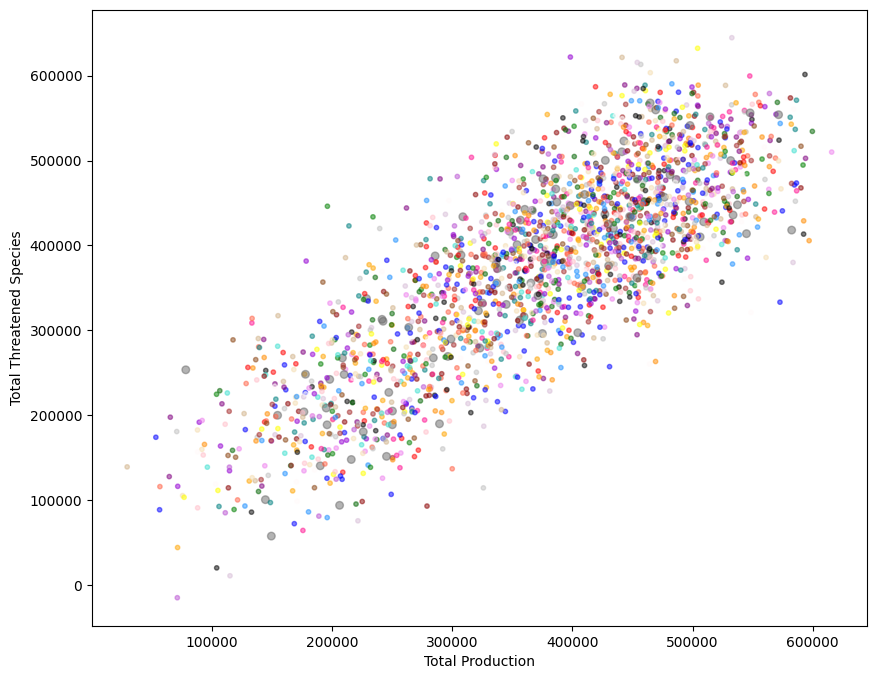

In [17]:
#Make points more visible using transparency and jitter

# Plot a scatter plot to compare the total production and total threatened species count for each country

# Extract x and y values using list comprehension
x_values = [row['Total Production'] for _, row in merged_df.iterrows()]
y_values = [row['Total Threatened Species'] for _, row in merged_df.iterrows()]

# Generate the random jitter values outside the loop
jitter_values = np.random.randn(len(merged_df), 2) * 50000

# Plot a scatter plot with jittered points
fig, ax = plt.subplots(figsize=(10, 8))
sizes = [marker_sizes.get(row['ISIC Description'], 10) for _, row in merged_df.iterrows()]
colors = [marker_colors.get(row['ISIC Description'], 'black') for _, row in merged_df.iterrows()]
ax.scatter(x_values + jitter_values[:, 0], y_values + jitter_values[:, 1], s=sizes, c=colors, alpha=0.5)

# Set labels for the x-axis and y-axis
ax.set_xlabel('Total Production')
ax.set_ylabel('Total Threatened Species')

In [28]:


# Create a data source for the scatter plot
source = ColumnDataSource(data={
    'x': x_values + jitter_values[:, 0],
    'y': y_values + jitter_values[:, 1],
    'size': [marker_sizes.get(row['ISIC Description'], 10) for _, row in merged_df.iterrows()],
    'color': [marker_colors.get(row['ISIC Description'], 'black') for _, row in merged_df.iterrows()],
    'country': [row['Country Description'] for _, row in merged_df.iterrows()],
    'product': [row['ISIC Description'] for _, row in merged_df.iterrows()]
})

# Set up the figure and add a scatter plot
fig = figure(title='Scatter Plot', width=800, height=600)
fig.scatter('x', 'y', size='size', color='color', alpha=0.5, source=source)

# Set labels for the x-axis and y-axis
fig.xaxis.axis_label = "Total Production"
fig.yaxis.axis_label = "Total Threatened Species"

# Add a hover tooltip that shows the country name
hover = HoverTool(tooltips=[("Country", "@country"), ("Total Production", "@x"), ("Total Threatened Species", "@y"), ("Industry", "@product")])
fig.add_tools(hover)


show(fig)

In [29]:
# Create a data source for the scatter plot
source = ColumnDataSource(data={
    'x': x_values,
    'y': y_values,
    'size': [marker_sizes.get(row['ISIC Description'], 10) for _, row in merged_df.iterrows()],
    'color': [marker_colors.get(row['ISIC Description'], 'black') for _, row in merged_df.iterrows()],
    'country': [row['Country Description'] for _, row in merged_df.iterrows()],
    'product': [row['ISIC Description'] for _, row in merged_df.iterrows()]
})

# Set up the figure and add a scatter plot
fig = figure(title='Scatter Plot', width=800, height=600)
fig.scatter('x', 'y', size='size', color='color', alpha=0.5, source=source)

# Set labels for the x-axis and y-axis
fig.xaxis.axis_label = "Total Production"
fig.yaxis.axis_label = "Total Threatened Species"

# Add a hover tooltip that shows the country name
hover = HoverTool(tooltips=[("Country", "@country"), ("Total Production", "@x"),
                  ("Total Threatened Species", "@y"), ("Industry", "@product")])
fig.add_tools(hover)


show(fig)
